In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom
from matplotlib.patches import Rectangle
from collections import namedtuple, defaultdict

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
PATH = Path('/home/paperspace/data/pneumonia/toy')

In [5]:
file2targets = pd.read_csv(PATH/'train_targets.csv')
file2targets.set_index('patientId', inplace=True)
train_n = file2targets.shape[0]
train_n

5000

In [6]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(1000,)

In [7]:
bs  = 128
arch = resnet34
sz=128

In [9]:
def class_data(sz):
    tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_targets.csv', val_idxs=val_idxs, tfms=tfms)
    return data

In [13]:
learn = ConvLearner.pretrained(arch, class_data(sz))

In [14]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

# Create and train model

 95%|█████████▌| 60/63 [00:04<00:00, 13.49it/s, loss=1.23] 


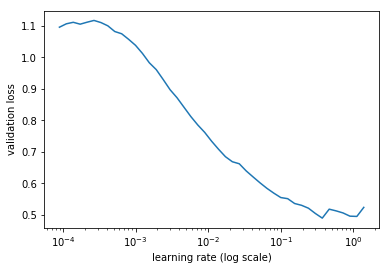

In [15]:
learn.lr_find()
learn.sched.plot()

In [16]:
learn.fit(1e-1, 4)

epoch      trn_loss   val_loss   accuracy                  
    0      0.143418   0.083577   0.985     
    1      0.105263   0.075063   0.985                     
    2      0.091042   0.076506   0.986                      
    3      0.065986   0.058079   0.986                      



[array([0.05808]), 0.986]

In [17]:
learn.unfreeze()

In [18]:
learn.fit(1e-2, 3, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.035786   0.009504   0.999     
    1      0.010599   0.004417   0.999                      
    2      0.011836   0.004408   0.999                       
    3      0.022529   0.006142   0.999                      
    4      0.007043   0.000371   1.0                         
    5      0.002059   0.001073   0.999                       
    6      0.001803   0.001347   0.999                        



[array([0.00135]), 0.999]

In [19]:
learn.fit(1e-3, 3, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.000156   0.00318    0.999     
    1      9.1e-05    0.002846   0.999                        
    2      4.8e-05    0.002335   0.999                        
    3      3.2e-05    0.002057   0.999                        
    4      4.2e-05    0.002293   0.999                        
    5      2.2e-05    0.002273   0.999                        
    6      3.4e-05    0.002138   0.999                        



[array([0.00214]), 0.999]

In [20]:
learn.save('toyclass')

In [21]:
learn.load('toyclass')

# Debug

In [22]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0) #mean out of 5 transforms
accuracy_np(probs, y)

0.999

[[762   0]
 [  1 237]]


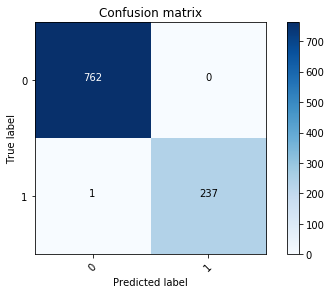

In [24]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, learn.data.classes)

In [29]:
wrong_idx =(preds != y).nonzero()
preds[wrong_idx], y[wrong_idx]

(array([0]), array([1]))

PosixPath('/home/paperspace/data/pneumonia/toy/train/35726244-0298-433e-9376-d1a1fe5724cf.png')

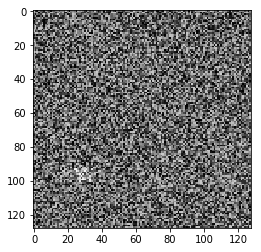

In [38]:
file = learn.data.val_ds.fnames[wrong_idx]
plt.imshow(PIL.Image.open(str(PATH/file[0])))
PATH/file[0]

# See augmentations